In [141]:
import os
from subprocess import PIPE, run
import time
import pandas as pd
import numpy as np 

def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

Data = pd.read_csv('/Users/sergiomares/Desktop/Nunez/Jin file/TSS_CpG_crispriphenotype_table.txt', delimiter = '\t',header = 0)

b = []

for i in range (1000):
    data = run(['curl', ('http://togows.org/api/ucsc/hg19/'+ str(Data['chromosome'][i])+':'+str(int(Data["Primary TSS, 5'"][i]-1000))+'-'+str(Data["Primary TSS, 5'"][i]+1000)+'.fasta/')], stdout=PIPE, stderr=PIPE, universal_newlines=True).stdout[:].replace('\n','')    
    b.append(data)
    if i % 1000 == 0: print(i)
    
#It took 106 minutes to comlpete all the sequences for 2.5 kb 

# 17 min for current states on 3000 only
#6000 took 36.15 min

0


In [388]:
Promoter_sequences = pd.DataFrame(b)

# Get all permutations of [1, 2, 3]
perm = ['A','C','G','T']
nucleotides = []

for p in range(1):
    for i in list(perm):
            for x in range(10):
                temp = '%s%s' % (x, i)
                nucleotides.append(temp)
    for z in range(len(Promoter_sequences)):
            for h in list(nucleotides):
                Promoter_sequences[0][z] = Promoter_sequences[0][z].replace(h,str((h[0],h[1])))
            if z % 1000 == 0:
                print(z)

Promoter_sequences[0] = Promoter_sequences[0].str.replace("'", "").str.replace(" ", "").str.replace("(", "").str.replace(")", "").str.replace(">hg19:", "")
Promoter_sequences = Promoter_sequences[0].str.split(",", expand = True)

0


Here you can select the length of the kmers used in the model

In [389]:
Promoter_sequences[2] = Promoter_sequences.apply(lambda x: getKmers(x[1], 3), axis = 1)
Promoter_sequences = Promoter_sequences.drop(1, axis =1 )
Promoter_sequences = Promoter_sequences.drop(0, axis =1 )

Promoter_sequences[3] =  pd.DataFrame([1 if x != '[]' else 0 for x in Data['CpG_location']])

The Scikit-learn library natural language processing tools do the k-mer counting. Here we convert the list into strings, which then get vectorized. The y variable will hold the class labels.

In [390]:
Promoters_text = list(Promoter_sequences[2])
for item in range(len(Promoters_text)):
    Promoters_text[item] = ' '.join(Promoters_text[item])
y_data = Promoter_sequences.iloc[:, 1].values                         

This is the Bag-of-words technique for natural language processing of text modelling.

In [391]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
#cv = CountVectorizer(ngram_range=(3,100))
X = cv.fit_transform(Promoters_text)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size = 0.20, random_state=42)

print(X.shape)

(1000, 64)


Here we graph the correspondent data of each of the Promoter sequences

<AxesSubplot:>

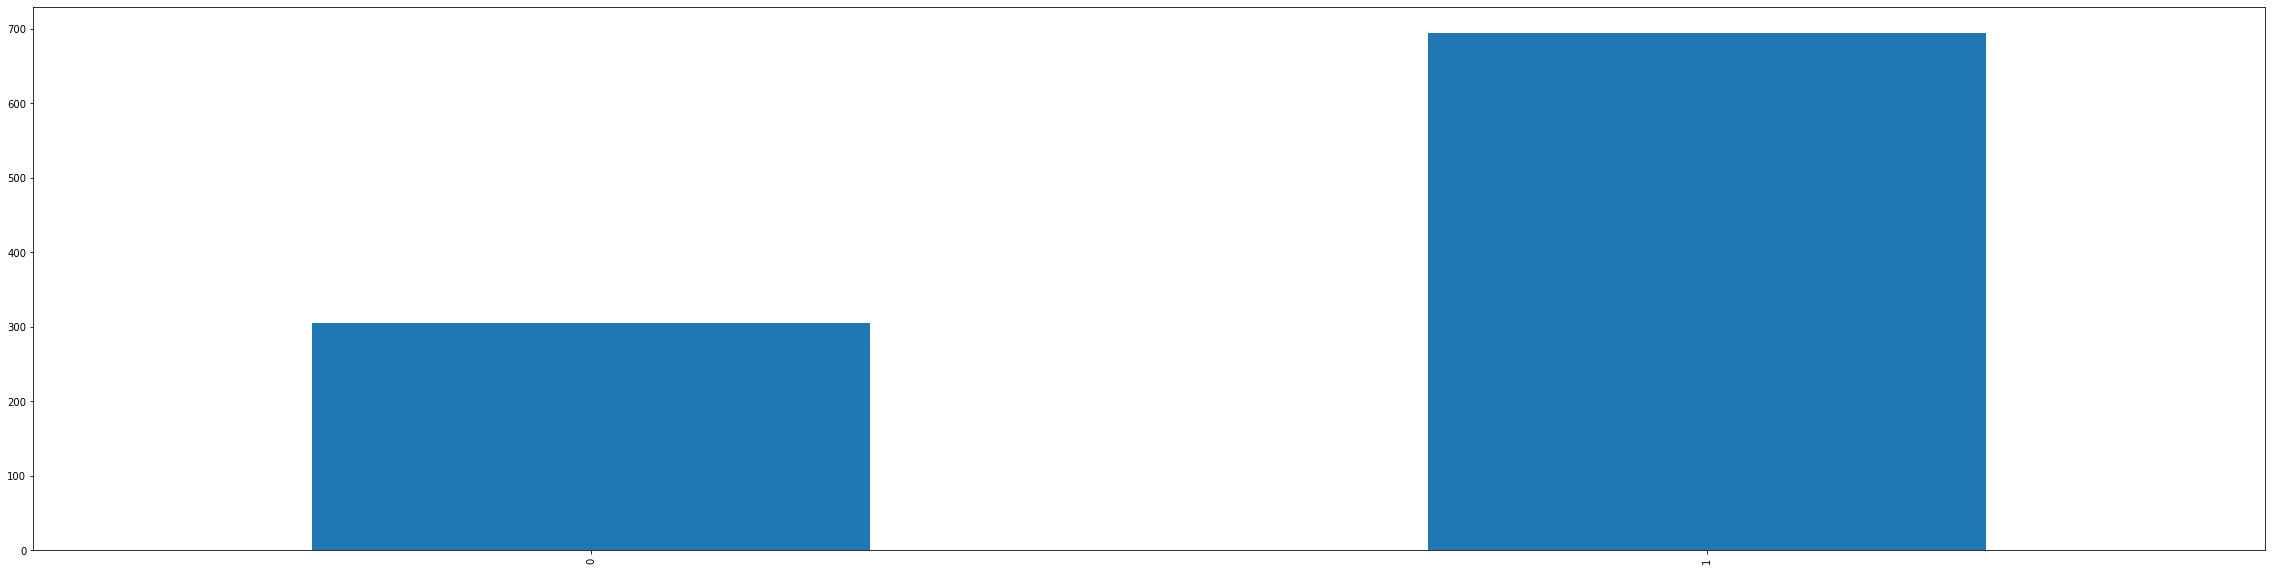

In [392]:
Promoter_sequences[3].value_counts().sort_index().plot.bar()

Here, the multinomal naive bayes classifier is used. More information at https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [393]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

Prediction:

In [394]:
y_pred = classifier.predict(X_test)

In [395]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted   0    1
Actual            
0          48    9
1          16  127
accuracy = 0.875 
precision = 0.881 
recall = 0.875 
f1 = 0.877


We can also graph the score for each of the combinations of letter, and compare significance.

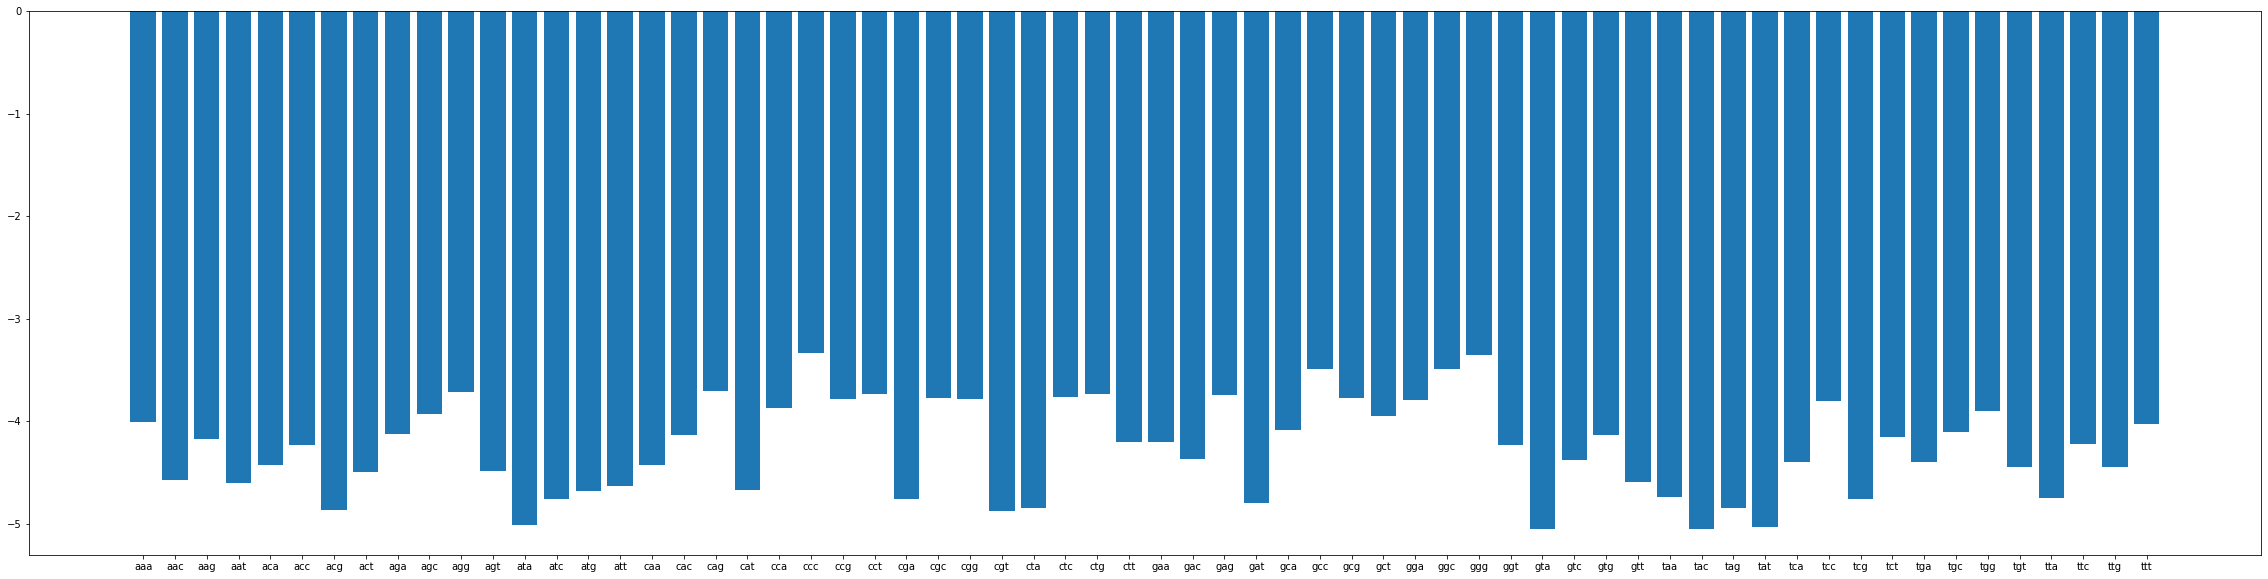

In [422]:
import matplotlib.pyplot as plt

weights = pd.DataFrame([cv.get_feature_names(), classifier.coef_[0]]).T
weights.sort_values(by = 1)

plt.bar(weights[0],weights[1])
plt.rcParams["figure.figsize"] = (40,10)
plt.show()

Genism, a Natural Language Processing Library for the Word2Vec algorithm

In [396]:
import gensim
from gensim.utils import simple_preprocess
Promoters_text = pd.DataFrame(Promoters_text, columns=['seq'])
Review_text = Promoters_text.seq.apply(simple_preprocess)

from gensim.models import Word2Vec

model = Word2Vec()
model.build_vocab(Review_text, progress_per=10)
model.train(Review_text, total_examples=model.corpus_count, epochs = model.epochs)

(3119270, 9995000)

In [399]:
model.wv.most_similar('cgc')
model.wv.similarity(w1 = "ccc", w2 = 'aaa')

-0.43508375

In [409]:
from numpy import dot
from numpy.linalg import norm

Promoter_sequences.columns = ['seq', 'cpgs']

def cosine_distance (model, word,target_list , num) :
    cosine_dict ={}
    word_list = []
    a = model[word]
    for item in target_list :
        if item != word :
            b = model [item]
            cos_sim = dot(a, b)/(norm(a)*norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in Descedning order 
    for item in dist_sort:
        word_list.append((item[0], item[1]))
    return word_list[0:num]
    
cosine_distance (model.wv,'cgc', Promoter_sequences.seq[1], 10)

[('cgg', 0.7520449),
 ('ggc', 0.56976336),
 ('cga', 0.5633306),
 ('ccc', 0.5489363),
 ('cgt', 0.5317842),
 ('gcc', 0.48759094),
 ('ccg', 0.47387692),
 ('gcg', 0.3623014),
 ('agc', 0.34399384),
 ('tgc', 0.3184208)]

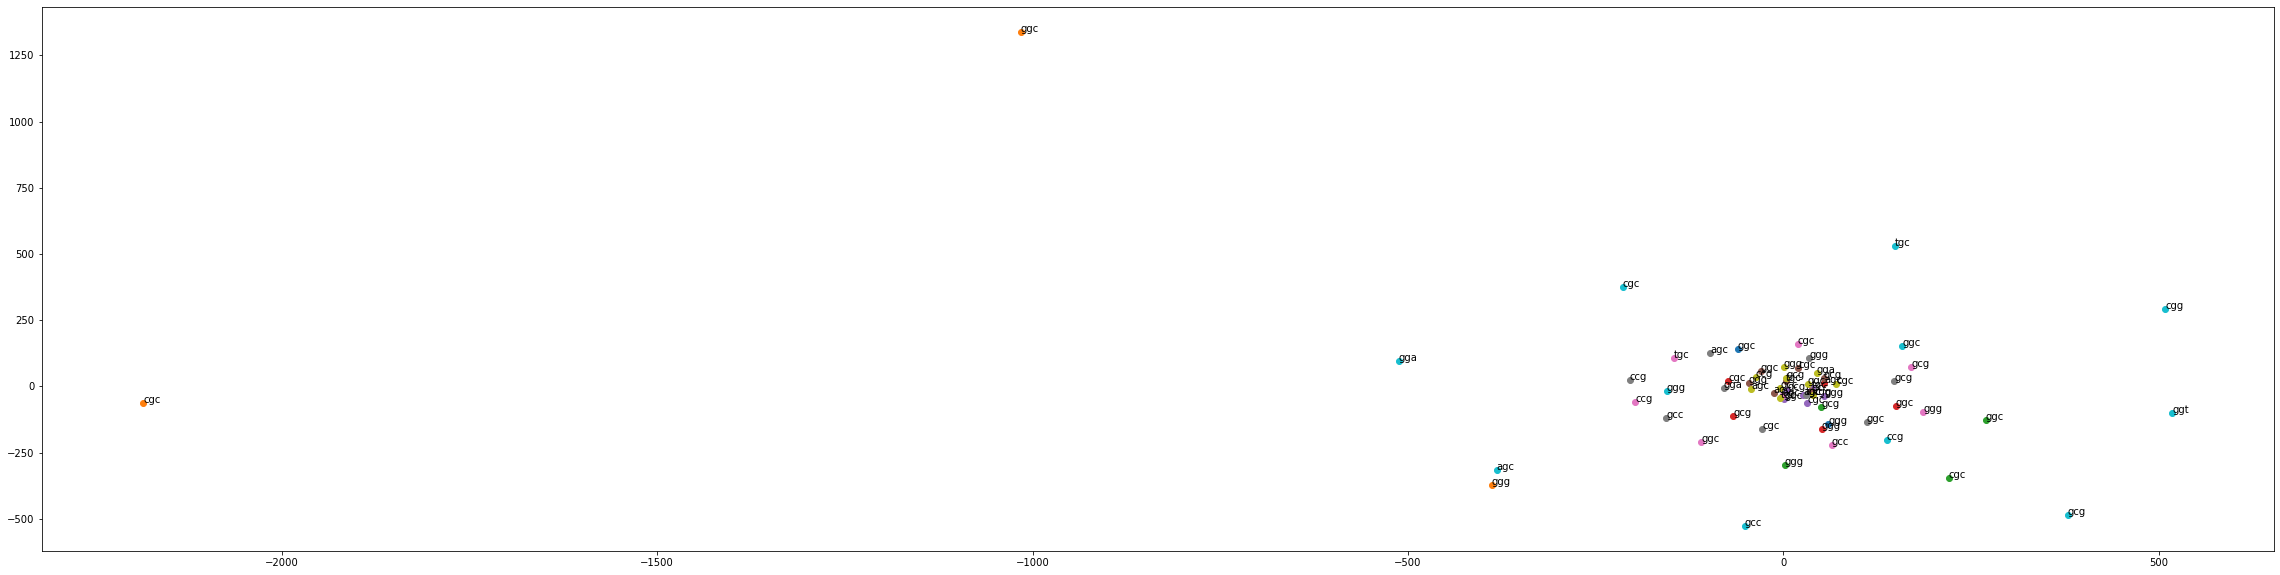

<Figure size 72x72 with 0 Axes>

In [421]:
from sklearn.manifold import TSNE
from matplotlib import figure
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

def display_closestwords_tsnescatterplot(model, word, size):
        
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]

    close_words = model.similar_by_word(word)

    arr = np.append(arr, np.array([model[word]]), axis=0)

    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
            
        tsne = TSNE(n_components=2, random_state=0)
        np.set_printoptions(suppress=True)
        Y = tsne.fit_transform(arr)

        x_coords = Y[:, 0]
        y_coords = Y[:, 1]
        plt.scatter(x_coords, y_coords)

        for label, x, y in zip(word_labels, x_coords, y_coords):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
            #plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
            #plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    
    plt.figure(figsize=(1,1))
    plt.show()

display_closestwords_tsnescatterplot(model.wv, 'ggc', 100) 

Adapted from https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92

In [247]:
from gensim.models import KeyedVectors

word_vectors = model.wv
word_vectors.save("word2vec.wordvectors")
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

Adapted the https://www.kaggle.com/marijakekic/cnn-in-keras-with-pretrained-word2vec-weights/notebook tutorial

In [119]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

NUM_WORDS=20000

tokenizer = Tokenizer()

tokenizer.fit_on_texts(Promoters_text.seq)
sequences_train = tokenizer.texts_to_sequences(Promoters_text.seq)
sequences_valid=tokenizer.texts_to_sequences(Promoters_text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train = pad_sequences(sequences_train)
y_train = to_categorical(Promoter_sequences[3])

EMBEDDING_DIM=10
vocabulary_size=min(len(word_index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

from keras.layers import Embedding

embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM)


Found 64 unique tokens.


In [121]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import adam_v2
from keras.models import Model
from keras import regularizers

sequence_length = X_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

# this creates a model that includes
model = Model(inputs, output)

In [126]:
import tensorflow as tf
import tensorflow.python.keras.backend as K 
sess = K.get_session()

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['acc'])

callbacks = [EarlyStopping(monitor='val_loss')]

#model.fit(X_train, y_train)